                                            Effects on the US Misery Index:
For this project I am hoping to answer the question :Does the S&P or the median House Price have an effect the Misery Index ?
In order to answer this question, I am planning on using metrics from three datasets (all metrics reported monthly) from quandl. The datasets that I am using are the Zillow, Yale, and US Misery. 

So far, I found that the correlation between the Median House Price and the US Misery Index is approximately -.80 and the correlation between the S&P and the US Misery Index is approximately -.84. This is to say that both the median house price and S&P are negatively correlated with the US Misery Index. I Also learned that the median house price increased by 30k from January 2018 to June 2019. Durning this same time period, the misery index has decreased from 6.25 to 5.3. lastly, as part of the misery index, the inflation rate has been varying less than the unemployment rate.

I always had a interest in topics related to housing, stocks, and the economy.Additionally, I never knew what the misery index was until I found a dataset in regards to it in Quandl. 

In [2]:
import scipy.stats as stats
import numpy as np

%matplotlib inline
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [3]:
import quandl
import pandas as pd


quandl.ApiConfig.api_key = 'TQnvQmTWu3_mxisgXmye'
medianlistprice=quandl.get('ZILLOW/M1_MLPAH', start_date='2010-12-31', end_date='2019-12-31') 
medianpricecut=quandl.get('ZILLOW/M1_MPCDAH', start_date='2010-12-31', end_date='2019-12-31') 
percentpricecut=quandl.get('ZILLOW/M1_PLPRAH', start_date='2010-12-31', end_date='2019-12-31') 



In [4]:

medianlistprice_df=pd.DataFrame(medianlistprice)
medianpricecut_df=pd.DataFrame(medianpricecut)
percentpricecut_df=pd.DataFrame(percentpricecut)


In [5]:

medianlistprice_df["medianlistprice"]=medianlistprice_df.values
medianpricecut_df["medianpricecut"]=medianpricecut_df.values
percentpricecut_df["percentpricecut"]=percentpricecut_df.values


In [6]:

del medianlistprice_df["Value"]
del medianpricecut_df["Value"]
del percentpricecut_df["Value"]


In [7]:

PriceConcat=pd.concat([medianlistprice_df,medianpricecut_df],axis=1,join="inner")
PriceConcatFinal=pd.concat([PriceConcat,percentpricecut_df],axis=1,join="inner")

In [8]:
#a healthy misery index is between 6 and 7 percent.
quandl.ApiConfig.api_key = 'TQnvQmTWu3_mxisgXmye'
Misery=quandl.get('USMISERY/INDEX', start_date='2010-12-31', end_date='2019-12-31')

In [9]:
Misery_df=pd.DataFrame(Misery)

In [10]:
MasterConcat=pd.concat([PriceConcatFinal,Misery_df],axis=1,join="inner")

In [11]:
quandl.ApiConfig.api_key = 'TQnvQmTWu3_mxisgXmye'
SPCOMP=quandl.get('YALE/SPCOMP', start_date='2010-12-31', end_date='2019-12-31')

In [12]:
SPCOMP_df=pd.DataFrame(SPCOMP)
SPCOMP_df_new = SPCOMP_df.rename(index={'Year': 'Date'})

In [13]:
MasterConcat=pd.concat([PriceConcatFinal,SPCOMP_df_new],axis=1,join="inner")

In [14]:
MasterConcatFinal=pd.concat([MasterConcat,Misery_df],axis=1,join="inner")

In [15]:
print(MasterConcatFinal)

            medianlistprice  medianpricecut  percentpricecut  S&P Composite  \
2010-09-30         199000.0         10000.0        15.060669    1122.080000   
2010-10-31         197000.0         10000.0        14.450634    1171.580000   
2010-11-30         194900.0         10000.0        11.978632    1198.890000   
2010-12-31         189500.0         10000.0        10.622925    1241.530000   
2011-01-31         185000.0         10000.0        13.187245    1282.620000   
2011-02-28         184900.0         10000.0        11.489166    1321.120000   
2011-03-31         187900.0         10000.0        13.894619    1304.490000   
2011-04-30         187500.0          9900.0        13.834944    1331.510000   
2011-05-31         189900.0          9999.0        13.964655    1338.310000   
2011-06-30         189900.0         10000.0        15.188460    1287.290000   
2011-07-31         189900.0         10000.0        14.865479    1325.190000   
2011-08-31         189900.0          9900.0        1

Here is the variation in Inflation 0.888068
Here is the variation in unemployment 1.914615
Here is the variation in the misery index 2.275636


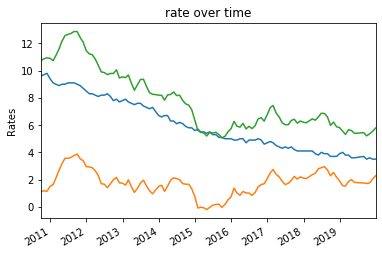

In [26]:

pricegrp=MasterConcatFinal["medianlistprice"]
miserygrp=MasterConcatFinal["Misery Index"]
unemploygrp=MasterConcatFinal["Unemployment Rate"]
Inflgrp=MasterConcatFinal["Inflation Rate"]

#miserygrp.plot(title="Misery Index over time") 
#sns.mpl.pyplot.ylabel("Misery Index") 

unemploygrp.plot(title="rate over time")
Inflgrp.plot()
miserygrp.plot()
sns.mpl.pyplot.ylabel("Rates") 
Unemploystd=MasterConcatFinal["Unemployment Rate"].std()
Inflstd=MasterConcatFinal["Inflation Rate"].std()
Miserystd=MasterConcatFinal["Misery Index"].std()

Unemploymean=MasterConcatFinal["Unemployment Rate"].mean()
Inflstdmean=MasterConcatFinal["Inflation Rate"].mean()

print(f'Here is the variation in Inflation {Inflstd:f}')
print(f'Here is the variation in unemployment {Unemploystd:f}')
print(f'Here is the variation in the misery index {Miserystd:f}')

Observations of Corrlations in the dataframe (MasterConcat) that includes housing information from zillow and the misery index. 


In [17]:
MasterConcatFinal.corr()

,medianlistprice,medianpricecut,percentpricecut,S&P Composite,Dividend,Earnings,CPI,Long Interest Rate,Real Price,Real Dividend,Real Earnings,Cyclically Adjusted PE Ratio,Unemployment Rate,Inflation Rate,Misery Index
medianlistprice,1.000000,-0.192684,0.387372,0.966146,0.959623,0.811260,0.949757,0.044459,0.960417,0.946603,0.732284,0.920113,-0.936918,-0.041140,-0.804335
medianpricecut,-0.192684,1.000000,0.339193,-0.360047,-0.371268,-0.229132,-0.352292,0.210694,-0.380208,-0.404433,-0.217620,-0.297525,0.428049,0.403455,0.517589
percentpricecut,0.387372,0.339193,1.000000,0.309012,0.296090,0.341507,0.322125,0.173852,0.300536,0.276589,0.320672,0.297668,-0.264809,0.031692,-0.210431
S&P Composite,0.966146,-0.360047,0.309012,1.000000,0.978456,0.863076,0.974976,0.042943,0.998454,0.969034,0.795828,0.954551,-0.958801,-0.082766,-0.838991
Dividend,0.959623,-0.371268,0.296090,0.978456,1.000000,0.814885,0.973400,-0.025246,0.976873,0.997784,0.735821,0.903633,-0.987331,-0.185875,-0.895180
Earnings,0.811260,-0.229132,0.341507,0.863076,0.814885,1.000000,0.887490,0.243200,0.844176,0.783905,0.990647,0.787015,-0.754957,0.103967,-0.587318
CPI,0.949757,-0.352292,0.322125,0.974976,0.973400,0.887490,1.000000,-0.037780,0.965117,0.958830,0.818613,0.891364,-0.944032,-0.007953,-0.797369
Long Interest Rate,0.044459,0.210694,0.173852,0.042943,-0.025246,0.243200,-0.037780,1.000000,0.047276,-0.050768,0.291769,0.209169,0.081880,0.321002,0.194161
Real Price,0.960417,-0.380208,0.300536,0.998454,0.976873,0.844176,0.965117,0.047276,1.000000,0.970565,0.776434,0.962141,-0.964960,-0.115572,-0.856976
Real Dividend,0.946603,-0.404433,0.276589,0.969034,0.997784,0.783905,0.958830,-0.050768,0.970565,1.000000,0.702611,0.895418,-0.992408,-0.231670,-0.917489


In [ ]:
MasterConcatFinal["Month_Year"]=pd.to_datetime(MasterConcatFinal.index.values,format="%m-%d-%y")

In [ ]:

MasterConcatFinal["Month"]=MasterConcatFinal["Month_Year"].dt.month
MasterConcatFinal["Year"]=MasterConcatFinal["Month_Year"].dt.year
print(MasterConcatFinal["Month"])
#if spmonth=MasterConcatFinal.groupby()
#NewMonth[m+1 for m in 
#MasterConcatFinal["Month_Year"]
def Quarter(month):
        if month==1:
            return 1
        elif month==2:
            return 1
        elif month==3:
            return 1
        elif month==4:
            return 2
        elif month==5:
            return 2
        elif month==6:
            return 2
        elif month==7:
            return 3
        elif month==8:
            return 3
        elif month==9:
            return 3
        elif month==10:
            return 4
        elif month==11:
            return 4
        else:
            return 4
MasterConcatFinal["Quarter"]=MasterConcatFinal.apply(\
                        lambda x:\
                                Quarter( x['Month']),
                                      axis=1)
print(MasterConcatFinal)

In [ ]:
x=pd.DataFrame(MasterConcatFinal.groupby(["Quarter"]).mean())
#x.corr()
y=pd.DataFrame(MasterConcatFinal.groupby(["Month"]).mean())
y.corr()